In [151]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd

#------------------------------------------------------
test_round = 1

# Get path to folders containing images
Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"  
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4
# "//20151125_BM_mTF8additionals_3//Composite_mBM-mTF8"


# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

assert len(Cherry_file) != len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"

# Initialize lists containing cherry, ypet images
cherry_imgs = []
ypet_imgs = []

# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range (test_round): #len(Cherry_file):
    cherry_imgs.append(imread(Cherry_file[i]))
    ypet_imgs.append(imread(Ypet_file[i]))

In [146]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels). None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold=0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)

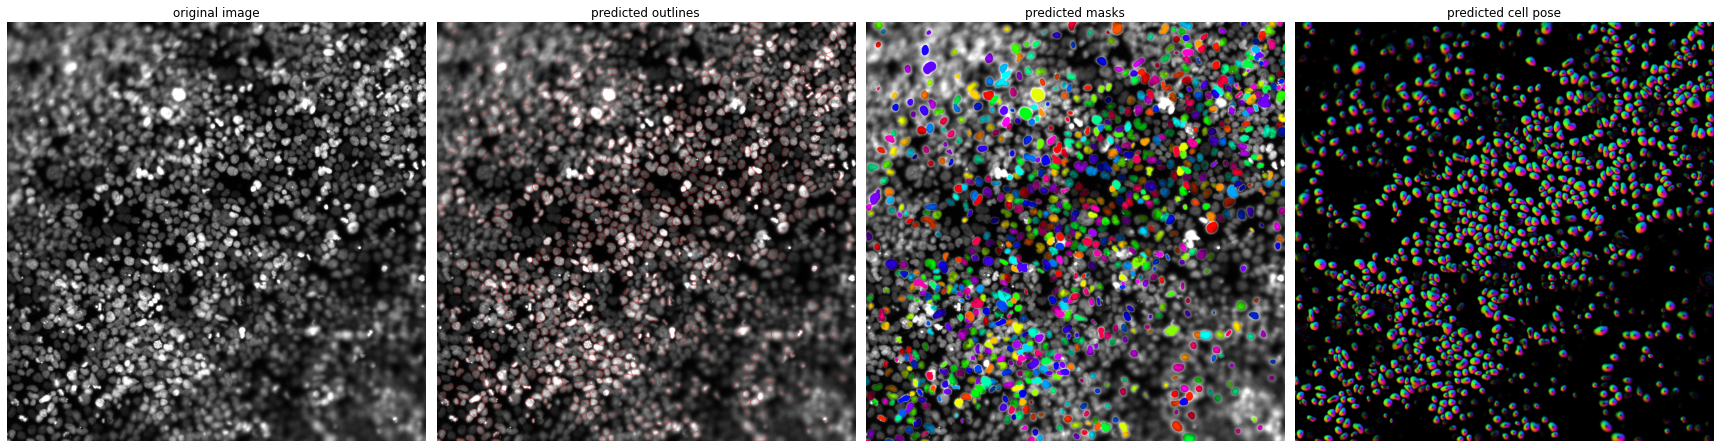

In [89]:
# Display results
image_i = 0
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

In [ ]:
# For future usage, save matrix
'''
mat.dump("my_matrix.dat")
mat2 = numpy.load("my_matrix.dat")'''

In [295]:
# Try with first image: masks[0]
masks_df =  pd.DataFrame(masks[0])
ypet_df = pd.DataFrame(ypet_imgs[0])
columnname = []
patch_size = []
mean_intensity = []

assert masks_df.shape == ypet_df.shape, f"Shape of mask is {masks_df.shape} and the shape of ypet image is { ypet_df.shape}. The size has to be the same. Check if normalization is needed"

# Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
for i in range (100): # masks_df.nunique().size 
    columnname.append("patch_" + str(i))
    patch_size.append((masks_df == i).values.sum())
    mean_intensity.append(np.nanmean(ypet_df[masks_df==i])) 

In [296]:
ypet_intensity = pd.DataFrame(index=columnname)
ypet_intensity['patch_size'] = patch_size
ypet_intensity['mean_intensity'] = mean_intensity

In [298]:
# Find relationship between nuclear size and expression level
# Apply ordinary least squares linear regression (For observational studies cross validation is not needed)
import statsmodels.formula.api as smf
mod = smf.ols(formula='patch_size ~ mean_intensity', data= ypet_intensity)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             patch_size   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.02244
Date:                Wed, 23 Nov 2022   Prob (F-statistic):              0.881
Time:                        17:40:32   Log-Likelihood:                -1412.5
No. Observations:                 100   AIC:                             2829.
Df Residuals:                      98   BIC:                             2834.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.999e+04   3.75e+05      0.